<a href="https://colab.research.google.com/github/Kush-Singh-26/Learning-Pytorch/blob/main/Instance_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import cv2
import random

In [2]:
np.random.seed(20)

In [3]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(
    weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT
)
_ = model.eval()


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 159MB/s]


In [4]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

COLORS = np.random.uniform(0, 255, size=(len(COCO_INSTANCE_CATEGORY_NAMES), 3))

In [5]:
def random_color_masks(image, colors):
    r, g, b = np.zeros_like(image, dtype=np.uint8), np.zeros_like(image, dtype=np.uint8), np.zeros_like(image, dtype=np.uint8)

    r[image == 1], g[image == 1], b[image == 1] = colors[random.randint(0, len(colors) - 1)]

    return np.stack([r, g, b], axis=2)

In [6]:
def get_prediction(img_path, threshold):

    img = Image.open(img_path)

    img_tensor = T.ToTensor()(img)

    with torch.no_grad():
        pred = model([img_tensor])

    pred_data = pred[0]
    scores = pred_data['scores'].detach().cpu().numpy()
    labels = pred_data['labels'].detach().cpu().numpy()
    boxes = pred_data['boxes'].detach().cpu().numpy()
    masks = (pred_data['masks'] > 0.5).squeeze().detach().cpu().numpy()

    valid_indices = scores > threshold
    if not np.any(valid_indices):
        return [], [], []

    pred_boxes = [[(b[0], b[1]), (b[2], b[3])] for b in boxes[valid_indices]]
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in labels[valid_indices]]
    masks = masks[valid_indices]

    return masks, pred_boxes, pred_class

In [7]:
import matplotlib.pyplot as plt

In [8]:
def instance_segmentation(img_path, threshold=0.5):

    masks, boxes, pred_cls = get_prediction(img_path, threshold)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    rect_th = max(round(sum(img.shape) / 2 * 0.003), 2)
    text_th = max(rect_th - 1, 1)

    for i in range(len(masks)):
        p1, p2 = (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1]))

        rgb_mask = random_color_masks(masks[i], COLORS)

        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)

        color = COLORS[COCO_INSTANCE_CATEGORY_NAMES.index(pred_cls[i])]

        cv2.rectangle(img, p1, p2, color=color, thickness=rect_th)

        w, h = cv2.getTextSize(pred_cls[i], 0, fontScale=rect_th / 3, thickness=text_th)[0]
        outside = p1[1] - h >= 3
        p2 = (p1[0] + w, p1[1] - h - 3) if outside else (p1[0] + w, p1[1] + h + 3)

        cv2.rectangle(img, p1, p2, color=color, thickness=-1, lineType=cv2.LINE_AA)

        cv2.putText(
            img,
            pred_cls[i],
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            rect_th / 3,
            (255, 255, 255),
            thickness=text_th + 1
        )

    plt.figure(figsize=(20, 17))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [10]:
img = Image.open('person-1.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

In [11]:
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)
with torch.no_grad():
    pred = model([img_tensor])

In [12]:
masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()

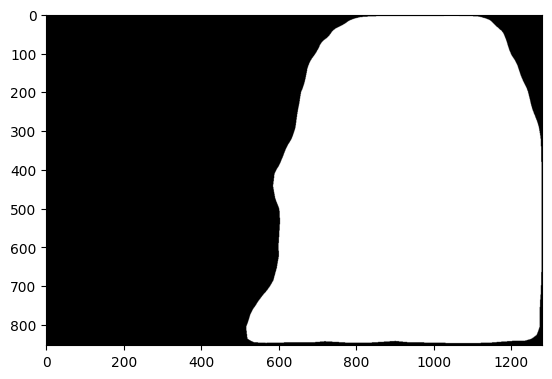

In [13]:
plt.imshow(masks[0],cmap='grey')

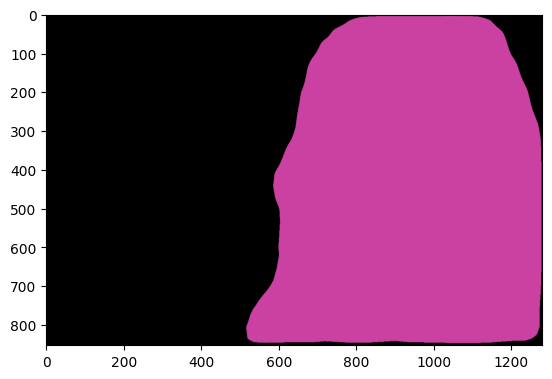

In [15]:
mask1 = random_color_masks(masks[0], COLORS)
plt.imshow(mask1)
plt.show()

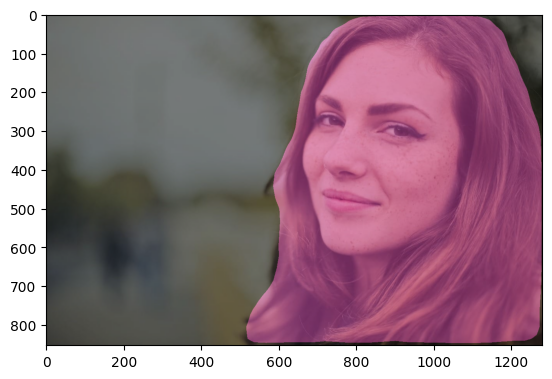

In [16]:
blend_img = cv2.addWeighted(np.asarray(img), 0.5, mask1, 0.5, 0)

plt.imshow(blend_img)
plt.show()

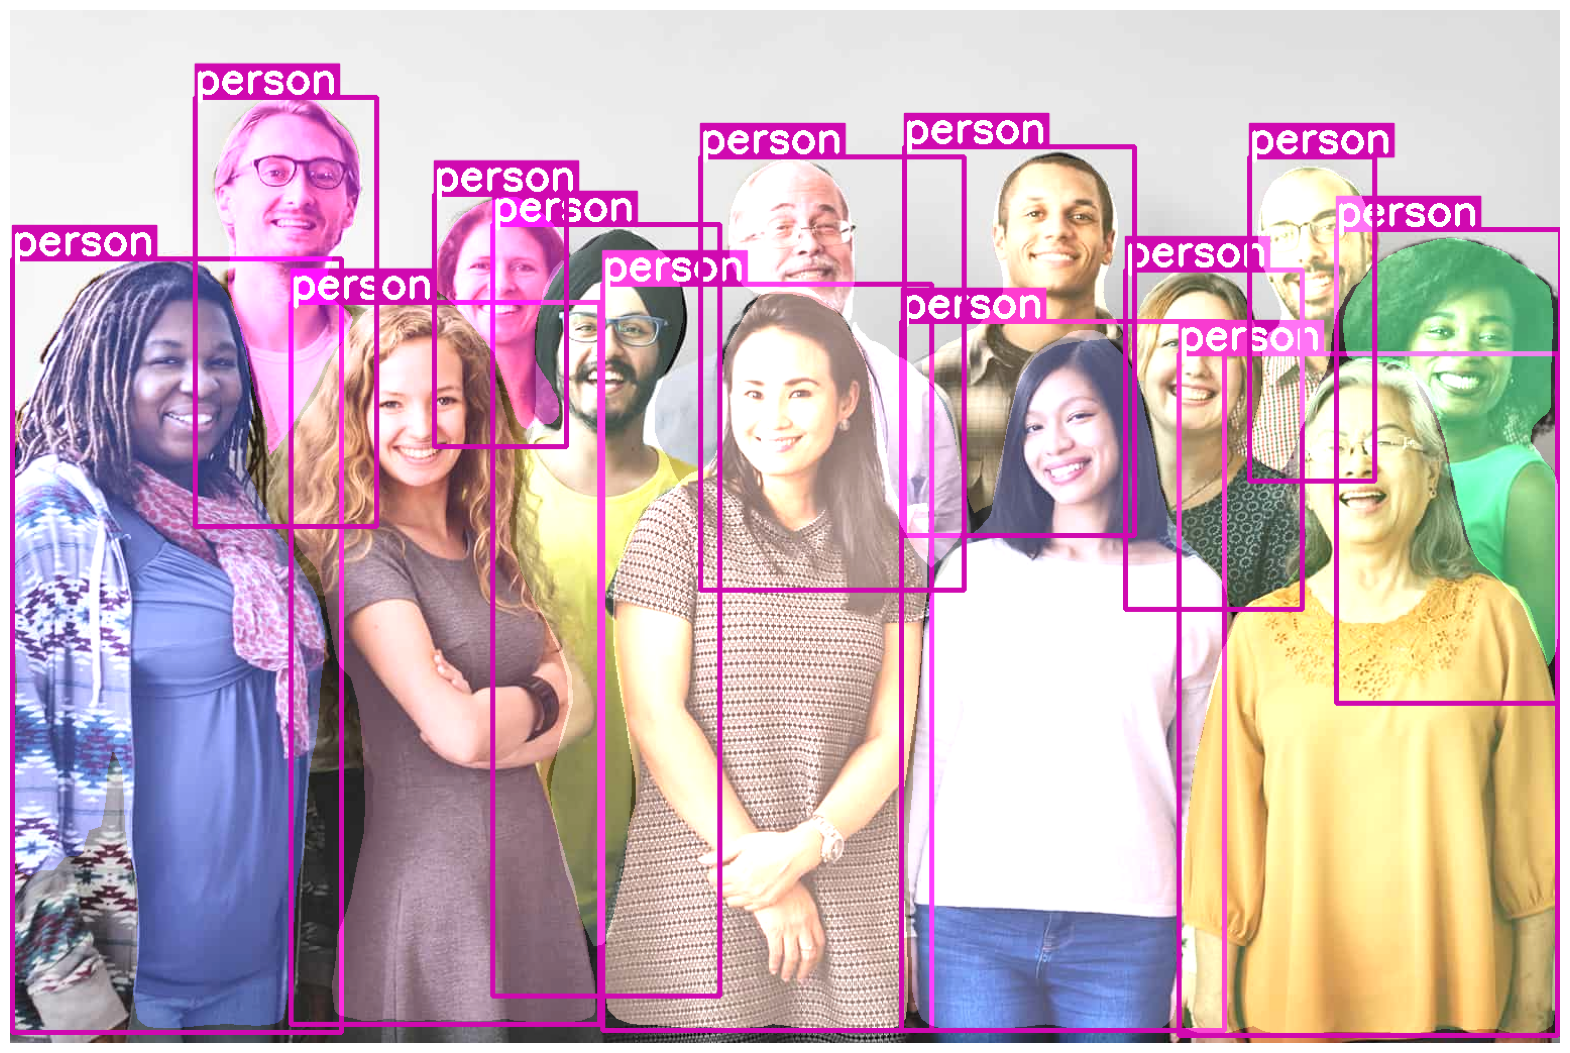

In [19]:
instance_segmentation('mrcnn_standing_people.jpg', 0.5)

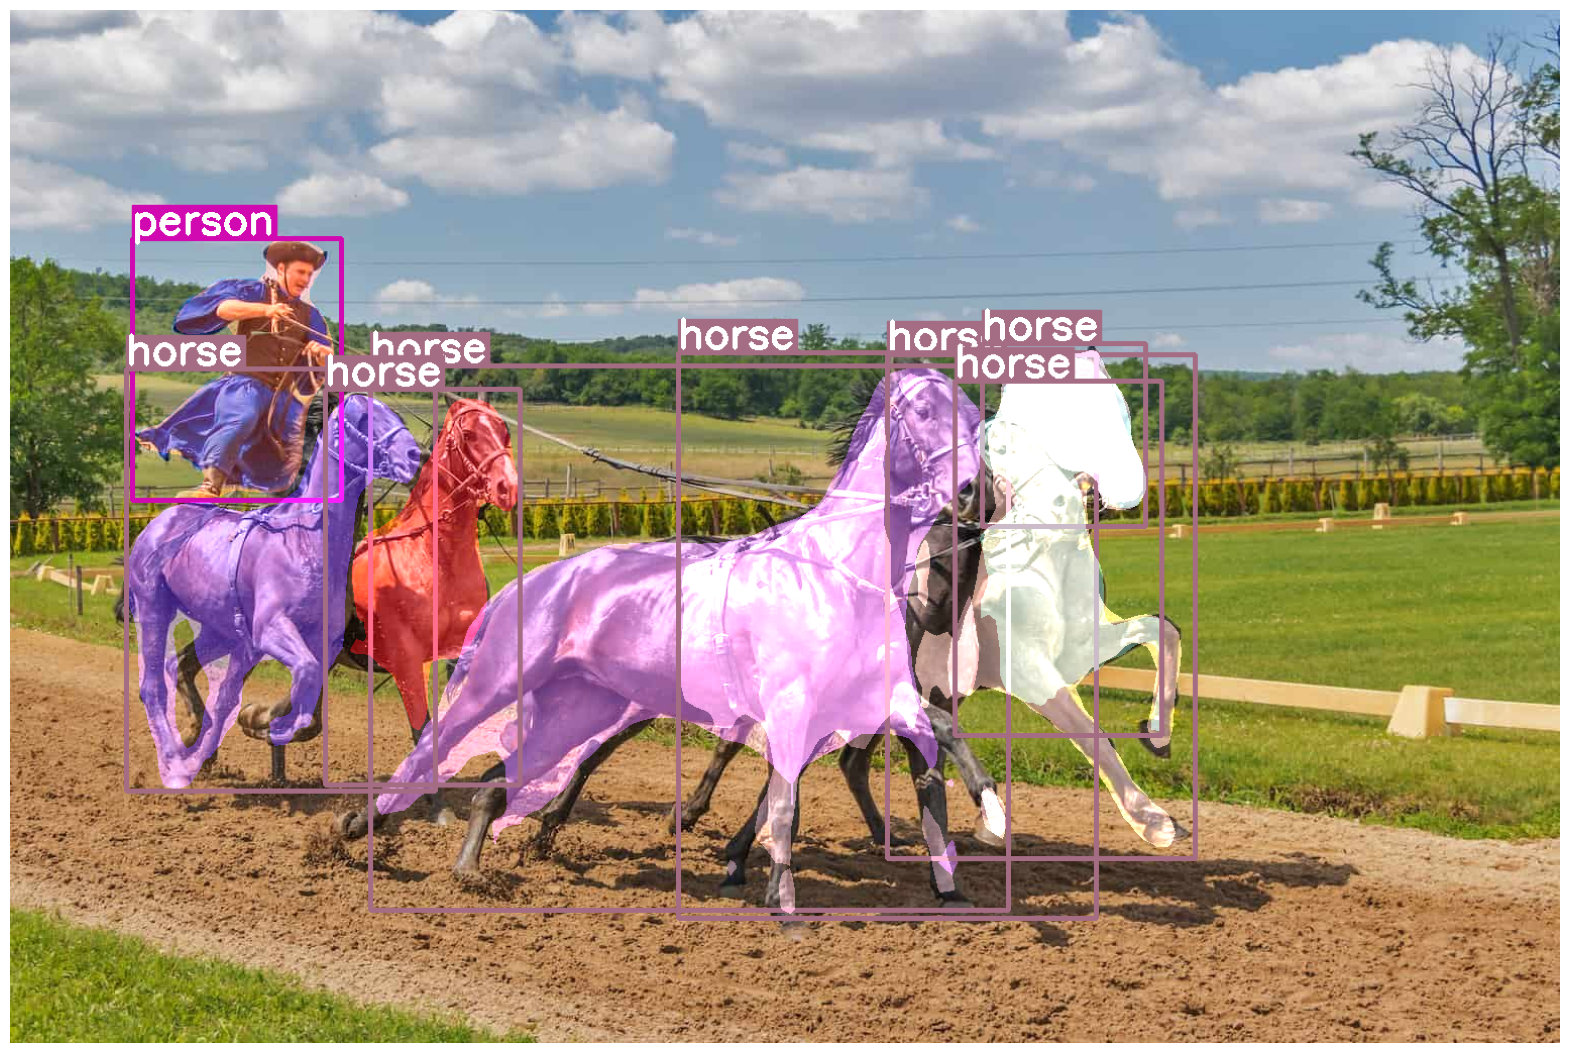

In [22]:
instance_segmentation('mrcnn-horses.jpg', 0.1)

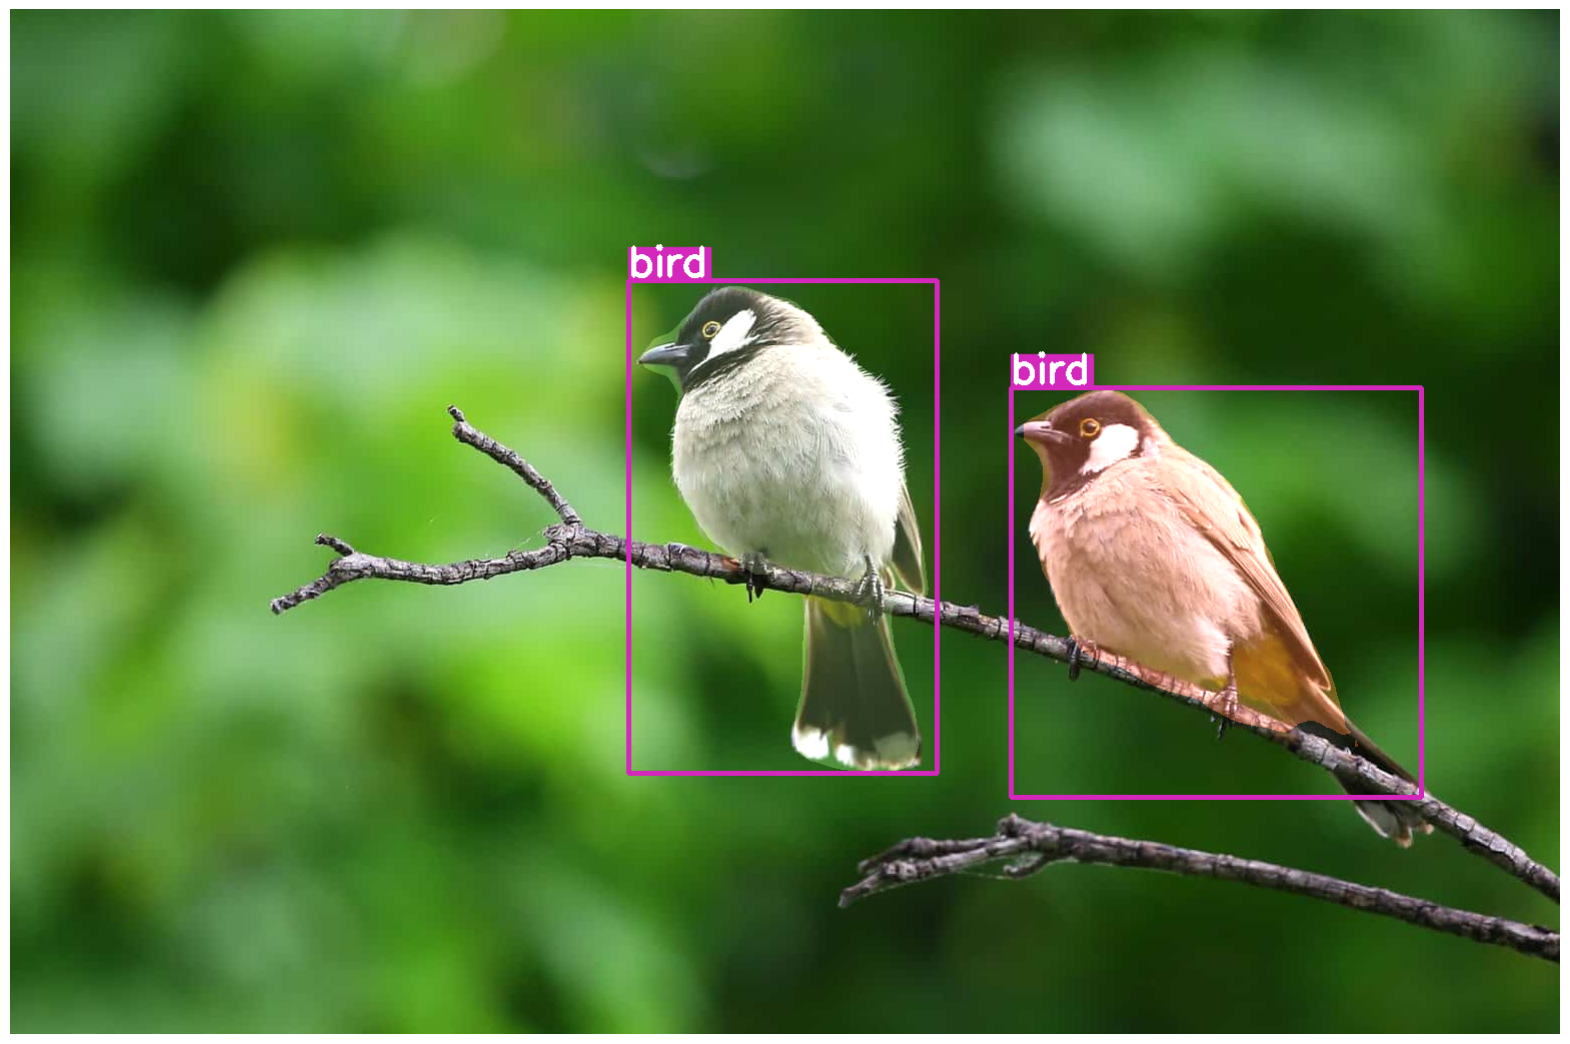

In [23]:
instance_segmentation('mrcnn-birds.jpg', 0.9)